In [1]:
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from Models.selective_sequential import *
from Loss.triplet_regularized import *
from session import *
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util
from session import LossMeter, EvalModel
from Layers.flatten import Flatten
from torch.utils.tensorboard import SummaryWriter

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/drake/anaconda3/envs/.

In [2]:
%load_ext autoreload
%autoreload 2

torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True;

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/torch/cuda/__init__.py:135: UserWarning: 
    Found GPU0 GeForce GTX 770 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/train', download=True, train=True, transform=transform)
partial_trainset = torch.utils.data.dataset.Subset(trainset, np.arange(1000))

valset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/test', download=True, train=False, transform=transform)
partial_valset = torch.utils.data.dataset.Subset(valset, np.arange(1000))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

In [5]:
select = ['max1', 'act1', 'out']
model = SelectiveSequential(
    select,
    {'conv64': nn.Conv2d(1, 64, kernel_size=5, padding=2),
     'act64': nn.ReLU(True),
     
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv192': nn.Conv2d(64, 192, kernel_size=5, padding=2),
     'act192': nn.ReLU(True),
    
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv384': nn.Conv2d(192, 384, kernel_size=3, padding=1),
     'act384': nn.ReLU(True),
     
     'conv256a': nn.Conv2d(384, 256, kernel_size=3, padding=1),
     'act256a': nn.ReLU(True),
     
     'conv256b': nn.Conv2d(256, 256, kernel_size=3, padding=1),
     'act256b': nn.ReLU(True),
     
     'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
     'fc1': nn.Linear(3 * 3 * 256, 512),
     'act1': nn.ReLU(True),
     'fc2': nn.Linear(512, 512),
     'act2': nn.ReLU(True),
     'out': nn.Linear(512, 10)})

In [6]:
criterion = TripletRegularizedMultiMarginLoss(0, .5)
sess = Session(model, criterion, optim.Adam, 1e-4)

In [7]:
validator = EmbeddingSpaceValidator(valloader, len(select)-1, CustomOneHotAccuracy, 
                                    model_file="./no-reg.ckpt.tar")
lr_scheduler = CosAnneal(len(trainloader)*70, T_mult=1, lr_min=1e-6)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])

In [8]:
sess.train(schedule, 70)

Validating: 100%|██████████| 157/157 [00:05<00:00, 30.15it/s]



val accuracy:  0.974 
train loss:  0.0115  train BCE :  0.4267 
valid loss:  0.009  valid BCE :  0.1723


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.02it/s]



val accuracy:  0.9818 
train loss:  0.0076  train BCE :  0.1594 
valid loss:  0.006  valid BCE :  0.1524


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.54it/s]



val accuracy:  0.9856 
train loss:  0.0047  train BCE :  0.1124 
valid loss:  0.0048  valid BCE :  0.0923


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.67it/s]



val accuracy:  0.9903 
train loss:  0.0041  train BCE :  0.096 
valid loss:  0.0034  valid BCE :  0.0636


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.67it/s]



val accuracy:  0.9896 
train loss:  0.0033  train BCE :  0.0793 
valid loss:  0.0037  valid BCE :  0.0624


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.36it/s]



val accuracy:  0.991 
train loss:  0.003  train BCE :  0.0622 
valid loss:  0.0026  valid BCE :  0.0665


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.55it/s]



val accuracy:  0.9916 
train loss:  0.0016  train BCE :  0.0573 
valid loss:  0.0025  valid BCE :  0.0485


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.52it/s]



val accuracy:  0.9913 
train loss:  0.0017  train BCE :  0.0458 
valid loss:  0.0027  valid BCE :  0.0512


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.50it/s]



val accuracy:  0.9924 
train loss:  0.002  train BCE :  0.0417 
valid loss:  0.0023  valid BCE :  0.0369


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.82it/s]



val accuracy:  0.9936 
train loss:  0.0012  train BCE :  0.0395 
valid loss:  0.0019  valid BCE :  0.0352


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.60it/s]



val accuracy:  0.9929 
train loss:  0.0012  train BCE :  0.033 
valid loss:  0.0023  valid BCE :  0.0399


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.30it/s]



val accuracy:  0.993 
train loss:  0.0014  train BCE :  0.0274 
valid loss:  0.0024  valid BCE :  0.0393


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.70it/s]



val accuracy:  0.9911 
train loss:  0.001  train BCE :  0.0218 
valid loss:  0.0029  valid BCE :  0.0371


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.25it/s]



val accuracy:  0.9928 
train loss:  0.0008  train BCE :  0.0231 
valid loss:  0.0026  valid BCE :  0.0447


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.46it/s]



val accuracy:  0.9921 
train loss:  0.0007  train BCE :  0.0183 
valid loss:  0.0028  valid BCE :  0.0283


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.79it/s]



val accuracy:  0.9923 
train loss:  0.0006  train BCE :  0.0134 
valid loss:  0.0028  valid BCE :  0.026


Validating: 100%|██████████| 157/157 [00:04<00:00, 32.00it/s]



val accuracy:  0.9944 
train loss:  0.0005  train BCE :  0.0157 
valid loss:  0.002  valid BCE :  0.0257


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.27it/s]



val accuracy:  0.9942 
train loss:  0.0007  train BCE :  0.0148 
valid loss:  0.0021  valid BCE :  0.0219


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.54it/s]



val accuracy:  0.9937 
train loss:  0.0004  train BCE :  0.0104 
valid loss:  0.0021  valid BCE :  0.0221


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.32it/s]



val accuracy:  0.995 
train loss:  0.0004  train BCE :  0.0121 
valid loss:  0.0021  valid BCE :  0.022


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.28it/s]



val accuracy:  0.9937 
train loss:  0.0003  train BCE :  0.0095 
valid loss:  0.0023  valid BCE :  0.0242


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.44it/s]



val accuracy:  0.9939 
train loss:  0.0004  train BCE :  0.0085 
valid loss:  0.0023  valid BCE :  0.0204


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.64it/s]



val accuracy:  0.9928 
train loss:  0.0002  train BCE :  0.0074 
valid loss:  0.0027  valid BCE :  0.023


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.40it/s]



val accuracy:  0.9912 
train loss:  0.0007  train BCE :  0.0056 
valid loss:  0.0037  valid BCE :  0.0314


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.05it/s]



val accuracy:  0.9942 
train loss:  0.0003  train BCE :  0.007 
valid loss:  0.0022  valid BCE :  0.0203


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.58it/s]



val accuracy:  0.9933 
train loss:  0.0005  train BCE :  0.0062 
valid loss:  0.0025  valid BCE :  0.0223


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.91it/s]



val accuracy:  0.9933 
train loss:  0.0001  train BCE :  0.0043 
valid loss:  0.0024  valid BCE :  0.0204


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.17it/s]



val accuracy:  0.9935 
train loss:  0.0002  train BCE :  0.0047 
valid loss:  0.0025  valid BCE :  0.0214


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.38it/s]



val accuracy:  0.9951 
train loss:  0.0002  train BCE :  0.0044 
valid loss:  0.0023  valid BCE :  0.019


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.02it/s]



val accuracy:  0.9934 
train loss:  0.0002  train BCE :  0.0036 
valid loss:  0.0027  valid BCE :  0.0215


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.52it/s]



val accuracy:  0.9933 
train loss:  0.0002  train BCE :  0.0038 
valid loss:  0.0031  valid BCE :  0.023


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.27it/s]



val accuracy:  0.9941 
train loss:  0.0001  train BCE :  0.0029 
valid loss:  0.0025  valid BCE :  0.02


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.39it/s]



val accuracy:  0.9937 
train loss:  0.0001  train BCE :  0.0029 
valid loss:  0.0028  valid BCE :  0.0212


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.28it/s]



val accuracy:  0.9944 
train loss:  0.0001  train BCE :  0.003 
valid loss:  0.0022  valid BCE :  0.0187


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.78it/s]



val accuracy:  0.9939 
train loss:  0.0  train BCE :  0.0026 
valid loss:  0.0027  valid BCE :  0.0188


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.78it/s]



val accuracy:  0.9946 
train loss:  0.0001  train BCE :  0.0022 
valid loss:  0.0025  valid BCE :  0.019


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.52it/s]



val accuracy:  0.9945 
train loss:  0.0001  train BCE :  0.0016 
valid loss:  0.0022  valid BCE :  0.017


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.38it/s]



val accuracy:  0.9943 
train loss:  0.0002  train BCE :  0.0016 
valid loss:  0.0027  valid BCE :  0.0193


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.38it/s]



val accuracy:  0.9937 
train loss:  0.0001  train BCE :  0.0016 
valid loss:  0.0031  valid BCE :  0.0236


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.54it/s]



val accuracy:  0.9945 
train loss:  0.0  train BCE :  0.0015 
valid loss:  0.0026  valid BCE :  0.0186


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.49it/s]



val accuracy:  0.995 
train loss:  0.0  train BCE :  0.0009 
valid loss:  0.0023  valid BCE :  0.0163


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.44it/s]



val accuracy:  0.9949 
train loss:  0.0001  train BCE :  0.001 
valid loss:  0.0024  valid BCE :  0.0178


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.32it/s]



val accuracy:  0.9942 
train loss:  0.0  train BCE :  0.0011 
valid loss:  0.003  valid BCE :  0.0202


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.43it/s]



val accuracy:  0.9937 
train loss:  0.0001  train BCE :  0.0008 
valid loss:  0.003  valid BCE :  0.0221


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.13it/s]



val accuracy:  0.9949 
train loss:  0.0  train BCE :  0.0008 
valid loss:  0.0028  valid BCE :  0.0207


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.90it/s]



val accuracy:  0.9947 
train loss:  0.0  train BCE :  0.0005 
valid loss:  0.0028  valid BCE :  0.0211


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.24it/s]



val accuracy:  0.9942 
train loss:  0.0  train BCE :  0.0006 
valid loss:  0.0025  valid BCE :  0.019


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.95it/s]



val accuracy:  0.9939 
train loss:  0.0  train BCE :  0.0005 
valid loss:  0.0032  valid BCE :  0.0228


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.12it/s]



val accuracy:  0.9948 
train loss:  0.0  train BCE :  0.0003 
valid loss:  0.0027  valid BCE :  0.02


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.51it/s]



val accuracy:  0.9947 
train loss:  0.0  train BCE :  0.0004 
valid loss:  0.0027  valid BCE :  0.0202


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.78it/s]



val accuracy:  0.9948 
train loss:  0.0  train BCE :  0.0005 
valid loss:  0.003  valid BCE :  0.0233


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.63it/s]



val accuracy:  0.9952 
train loss:  0.0  train BCE :  0.0004 
valid loss:  0.0028  valid BCE :  0.0221


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.33it/s]



val accuracy:  0.9945 
train loss:  0.0  train BCE :  0.0003 
valid loss:  0.003  valid BCE :  0.0232


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.20it/s]



val accuracy:  0.9941 
train loss:  0.0  train BCE :  0.0003 
valid loss:  0.0033  valid BCE :  0.0253


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.35it/s]



val accuracy:  0.9947 
train loss:  0.0  train BCE :  0.0002 
valid loss:  0.0028  valid BCE :  0.0224


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.52it/s]



val accuracy:  0.9951 
train loss:  0.0  train BCE :  0.0002 
valid loss:  0.0028  valid BCE :  0.0215


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.65it/s]



val accuracy:  0.9951 
train loss:  0.0  train BCE :  0.0002 
valid loss:  0.0028  valid BCE :  0.0215


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.47it/s]



val accuracy:  0.9951 
train loss:  0.0  train BCE :  0.0002 
valid loss:  0.0028  valid BCE :  0.0215


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.67it/s]



val accuracy:  0.9951 
train loss:  0.0  train BCE :  0.0002 
valid loss:  0.0028  valid BCE :  0.0215


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.94it/s]



val accuracy:  0.9951 
train loss:  0.0  train BCE :  0.0002 
valid loss:  0.0028  valid BCE :  0.0215


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.41it/s]



val accuracy:  0.9951 
train loss:  0.0  train BCE :  0.0002 
valid loss:  0.0028  valid BCE :  0.0215


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.93it/s]



val accuracy:  0.9951 
train loss:  0.0  train BCE :  0.0002 
valid loss:  0.0028  valid BCE :  0.0215


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.06it/s]



val accuracy:  0.9951 
train loss:  0.0  train BCE :  0.0002 
valid loss:  0.0028  valid BCE :  0.0215


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.31it/s]



val accuracy:  0.9951 
train loss:  0.0  train BCE :  0.0002 
valid loss:  0.0028  valid BCE :  0.0215


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.25it/s]



val accuracy:  0.9951 
train loss:  0.0  train BCE :  0.0002 
valid loss:  0.0028  valid BCE :  0.0215


Validating: 100%|██████████| 157/157 [00:04<00:00, 31.82it/s]



val accuracy:  0.9951 
train loss:  0.0  train BCE :  0.0002 
valid loss:  0.0028  valid BCE :  0.0215


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.72it/s]



val accuracy:  0.9951 
train loss:  0.0  train BCE :  0.0002 
valid loss:  0.0028  valid BCE :  0.0215


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.38it/s]



val accuracy:  0.9951 
train loss:  0.0  train BCE :  0.0002 
valid loss:  0.0028  valid BCE :  0.0215


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.51it/s]



val accuracy:  0.9951 
train loss:  0.0  train BCE :  0.0002 
valid loss:  0.0028  valid BCE :  0.0215


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.40it/s]



val accuracy:  0.9951 
train loss:  0.0  train BCE :  0.0002 
valid loss:  0.0028  valid BCE :  0.0215



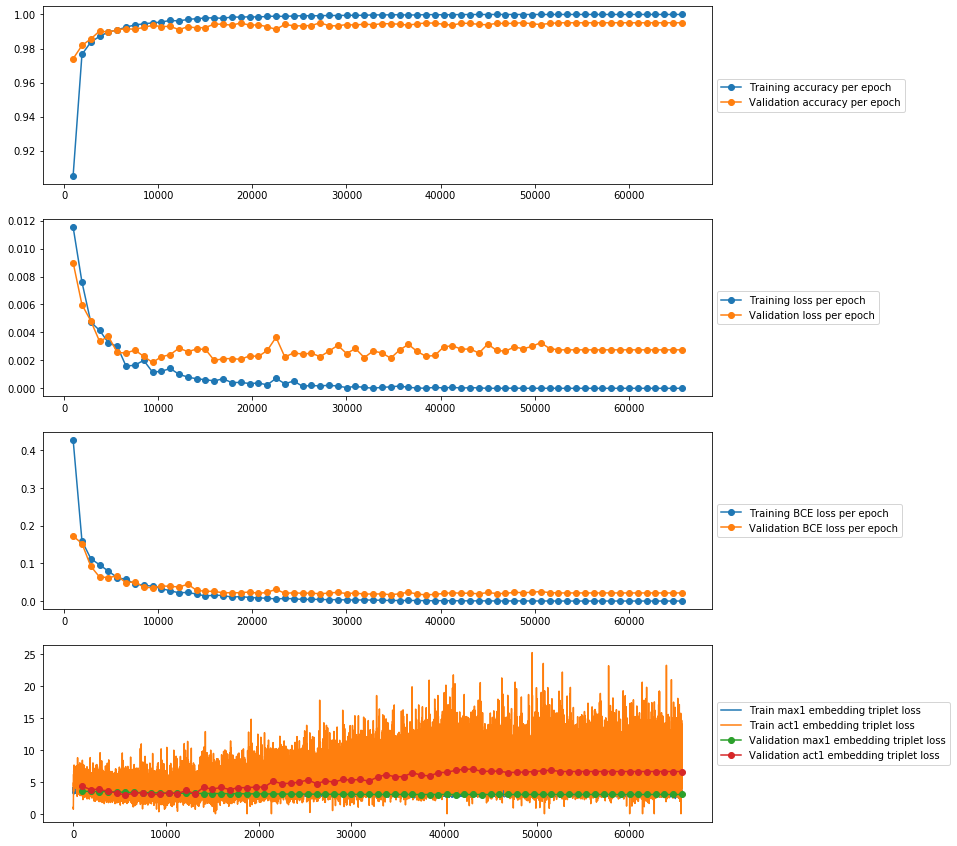

In [9]:
validator.plot()

In [10]:
sess.load("./no-reg.ckpt.tar")

In [11]:
total_valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
total_validator = EmbeddingSpaceValidator(total_valloader, len(select)-1, CustomOneHotAccuracy)

total_validator.run(sess)

Validating: 100%|██████████| 157/157 [00:05<00:00, 30.58it/s]


In [12]:
np.max(total_validator.val_accuracies), "Best accuracy without reg"

(0.9951, 'Best accuracy without reg')

In [13]:
visualization_set = torch.utils.data.dataset.Subset(valset, np.arange(500))
dataloader = torch.utils.data.DataLoader(visualization_set, batch_size=64, shuffle=False)

tensorboard_embeddings(model, ['max1'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_noreg')

tensorboard_embeddings(model, ['max2'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_noreg')

tensorboard_embeddings(model, ['max3'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_noreg')

tensorboard_embeddings(model, ['act1'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_noreg')

tensorboard_embeddings(model, ['act2'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_noreg')

tensorboard_embeddings(model, ['out'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_noreg')